In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm
import warnings

In [2]:
data_files = sorted(glob('./data/*'))

In [3]:
all_dfs = []
for f in data_files[8:12]:
    all_dfs.append(pd.read_csv(f))

df = pd.concat(all_dfs).reset_index(drop=True)

del all_dfs

In [4]:
df = df.rename(columns={'next-hop': 'next_hop', 'as-path': 'as_path'})

# AS

In [5]:
df['origin_asn'] = df.as_path.apply(lambda x: x.split(' ')[-1] if type(x)==str else None)
origin_asn_fill = df.groupby('prefix')['origin_asn'].last().to_frame()
df_origin_asn_fill = df[df.origin_asn.isna()].join(origin_asn_fill, on='prefix', rsuffix='_fill')
df.loc[df_origin_asn_fill.index, 'origin_asn'] = df_origin_asn_fill['origin_asn']
df = df.dropna(subset='origin_asn')

In [6]:
df_17557 = df[df.origin_asn=='17557']
timestamps_extended = np.arange(int(df_17557.time.min()), int(df_17557.time.max()))
df_17557 = df_17557.astype({'time': int})\
                   .groupby('time')[['prefix']]\
                   .count()\
                   .rename(columns={'prefix': 'updates'})\
                   .reindex(timestamps_extended)\
                   .fillna(0)

In [7]:
df_45609 = df[df.origin_asn=='45609']
timestamps_extended = np.arange(int(df_45609.time.min()), int(df_45609.time.max()))
df_45609 = df_45609.astype({'time': int})\
                   .groupby('time')[['prefix']]\
                   .count()\
                   .rename(columns={'prefix': 'updates'})\
                   .reindex(timestamps_extended)\
                   .fillna(0)

In [8]:
def prettify_fig(fig, width=10, height=5, xticks=None):
    fig.set_figwidth(width)
    fig.set_figheight(height)
    if xticks:
        ax = fig.get_axes()
        ax[0].set_xticks(xticks)

/home/user/Git/pybgpstream-test/venv/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:580: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


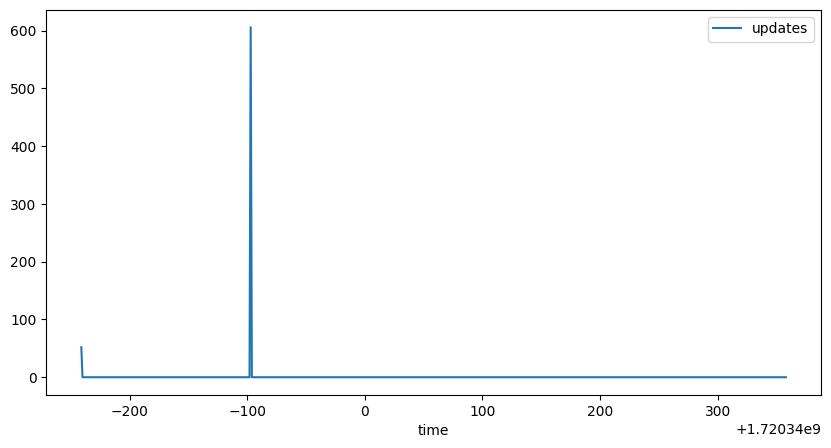

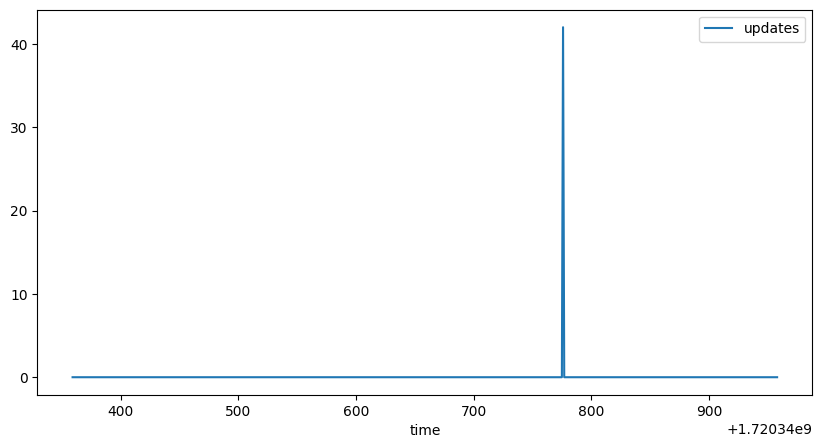

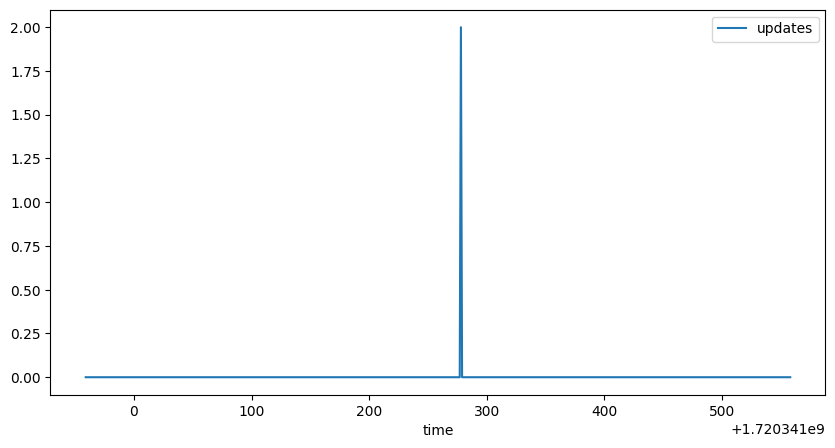

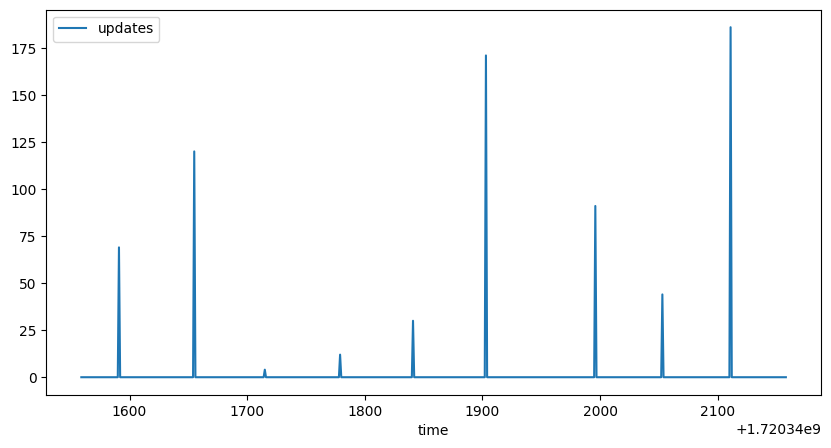

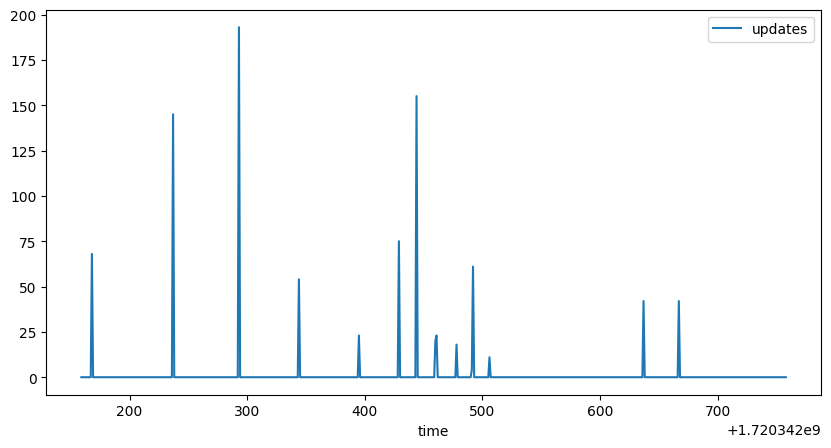

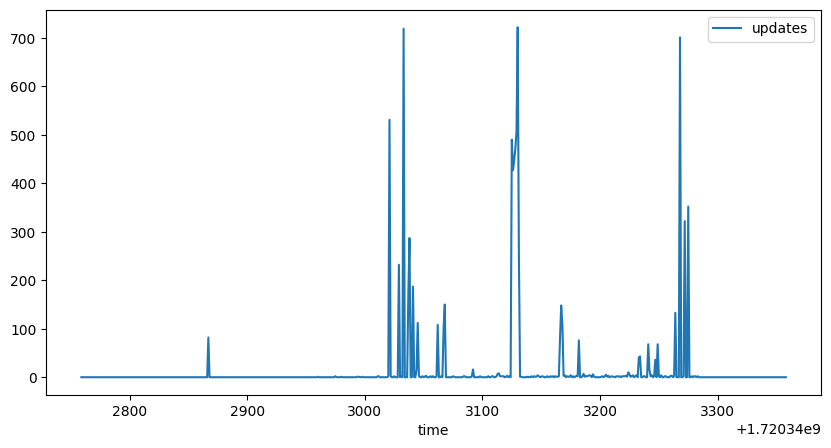

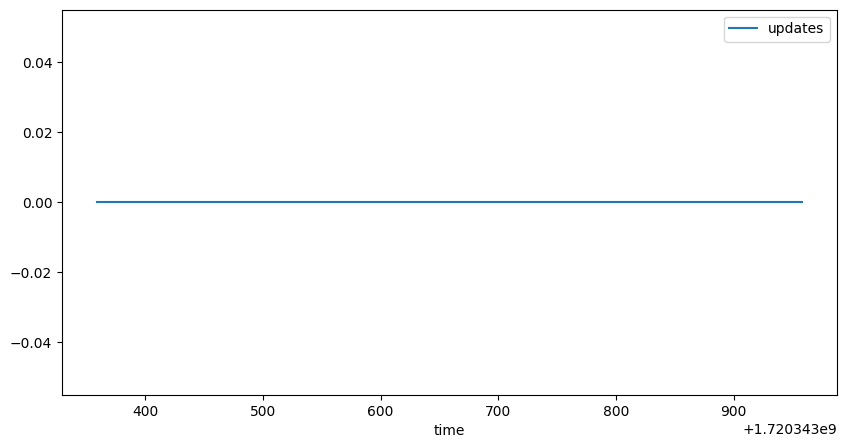

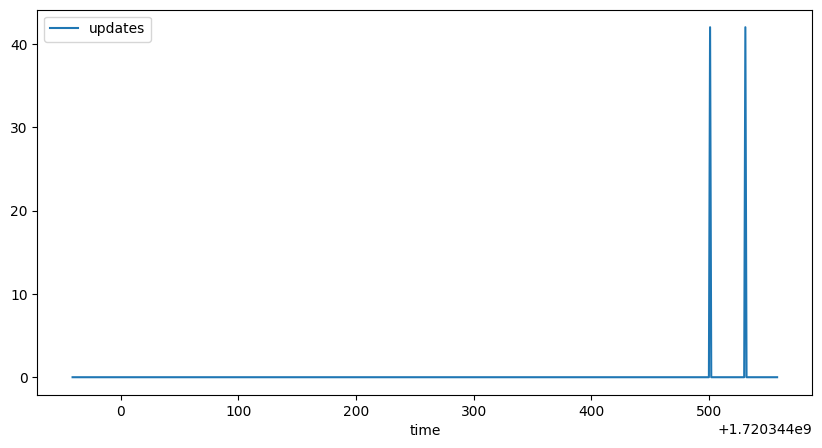

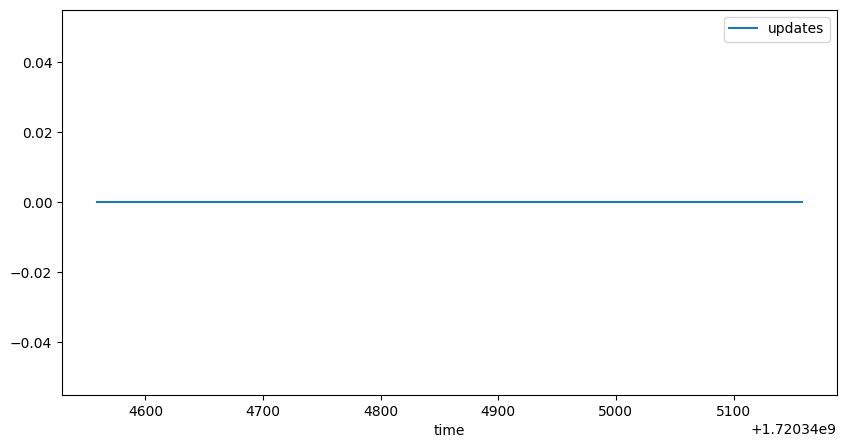

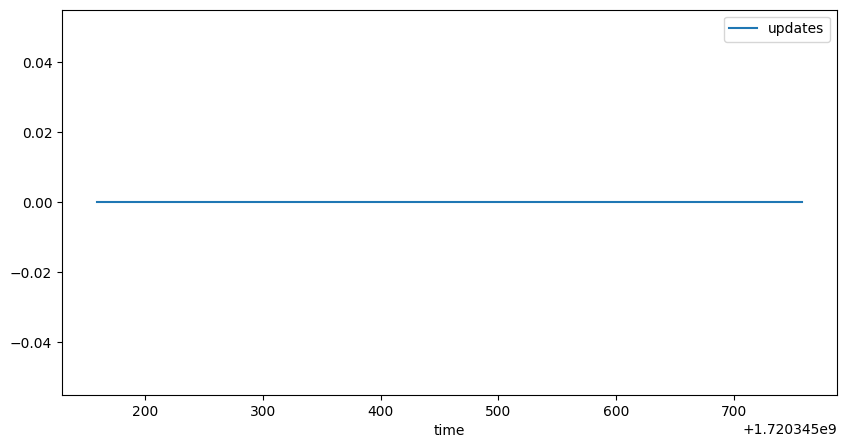

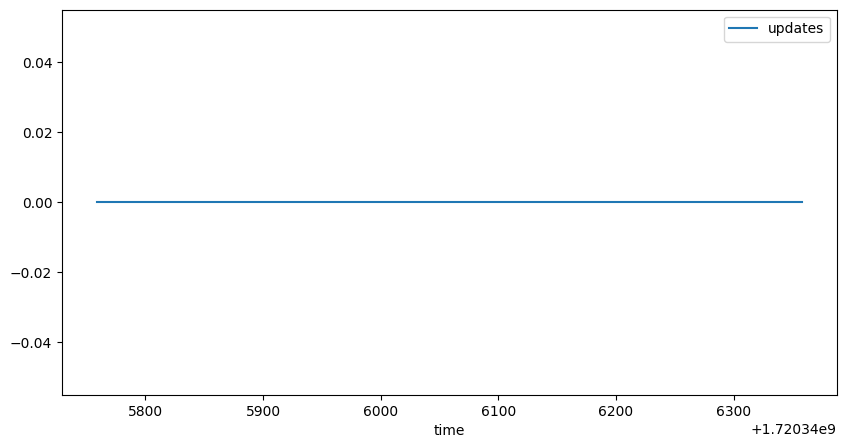

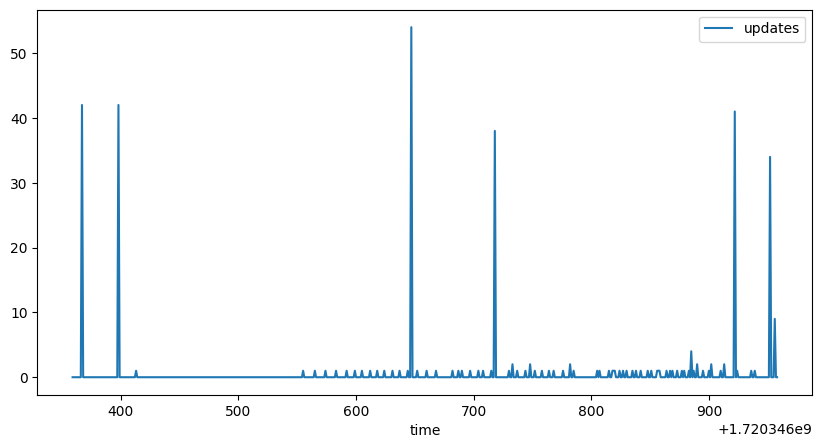

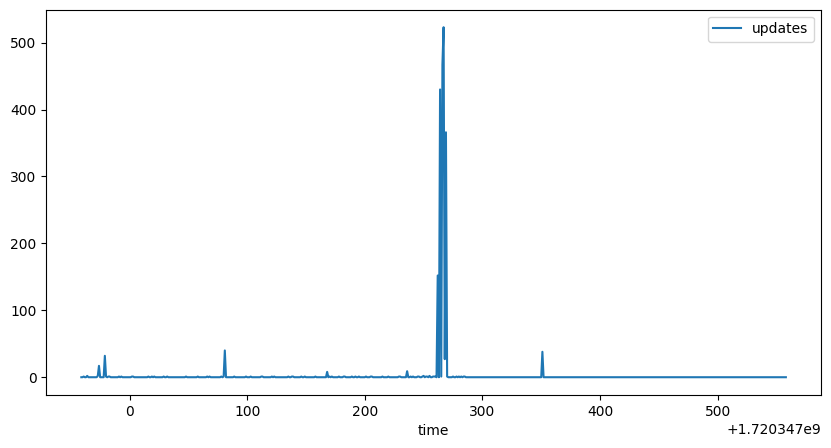

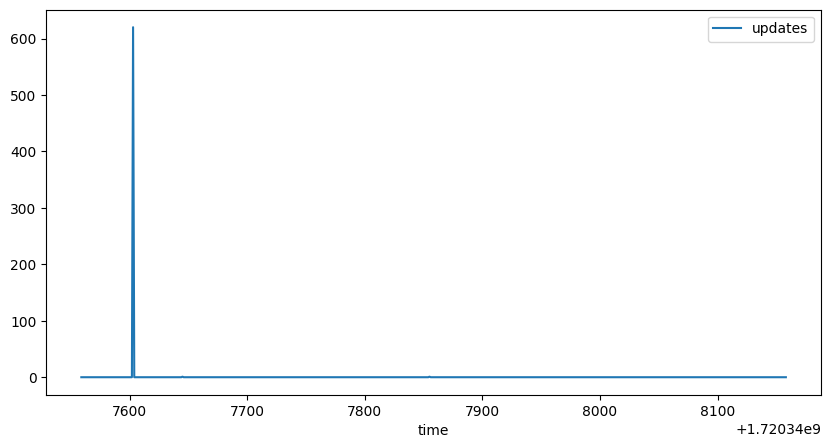

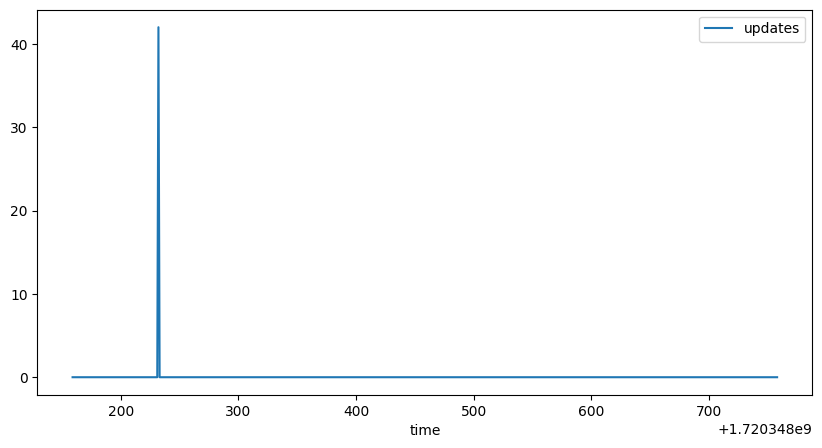

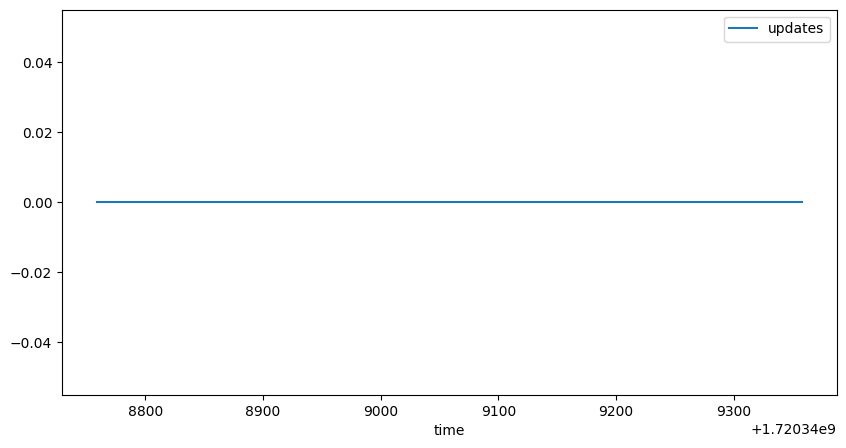

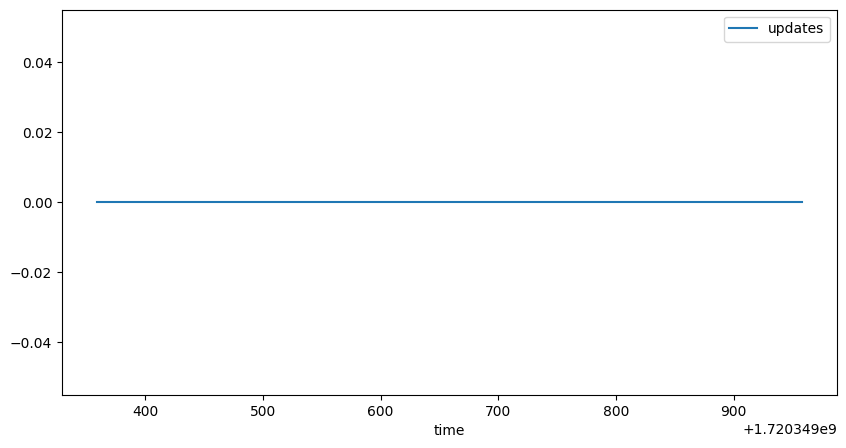

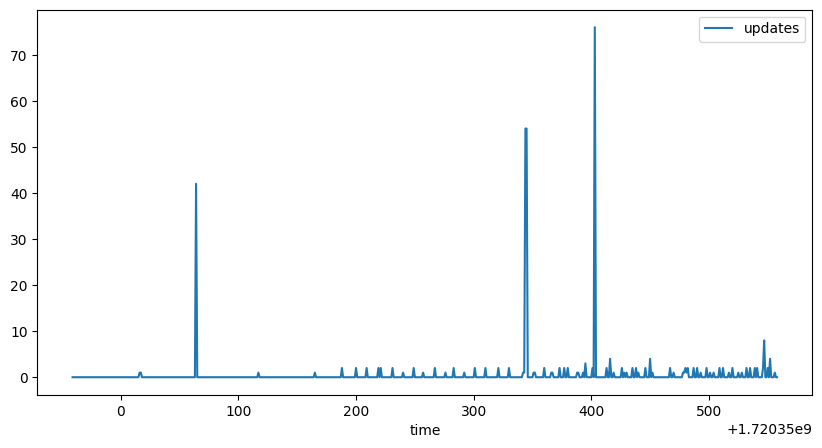

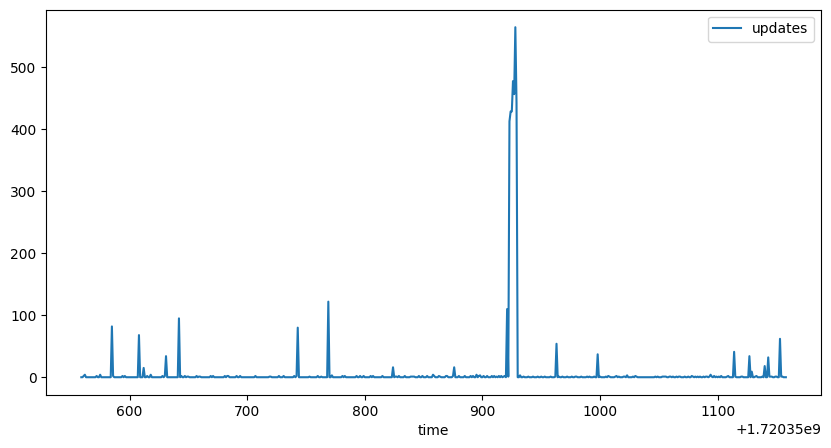

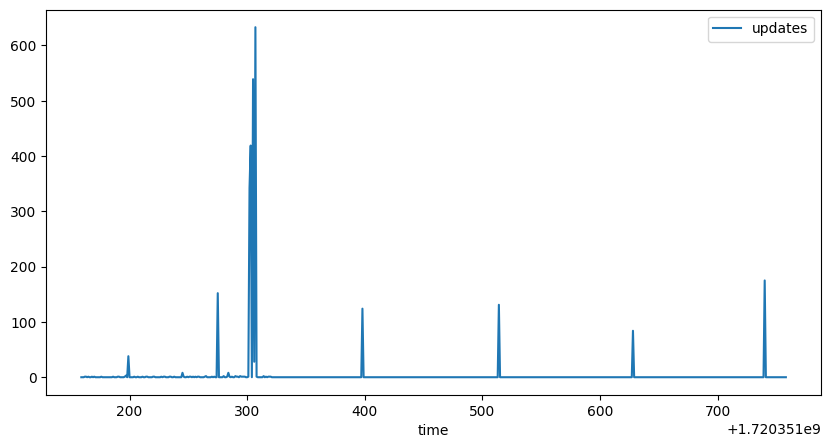

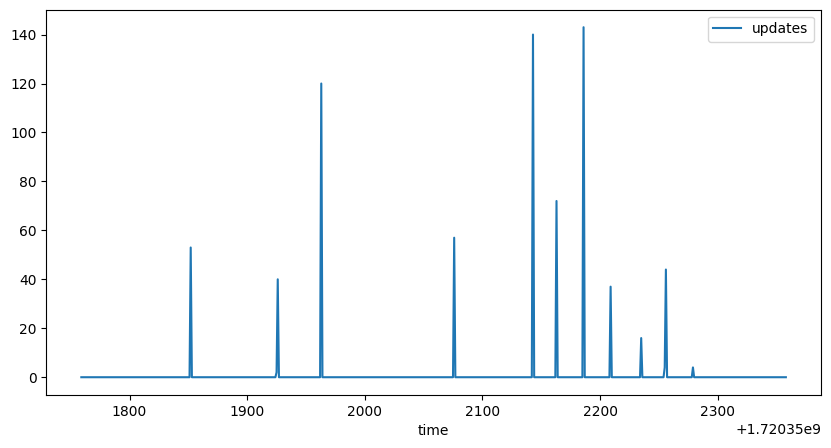

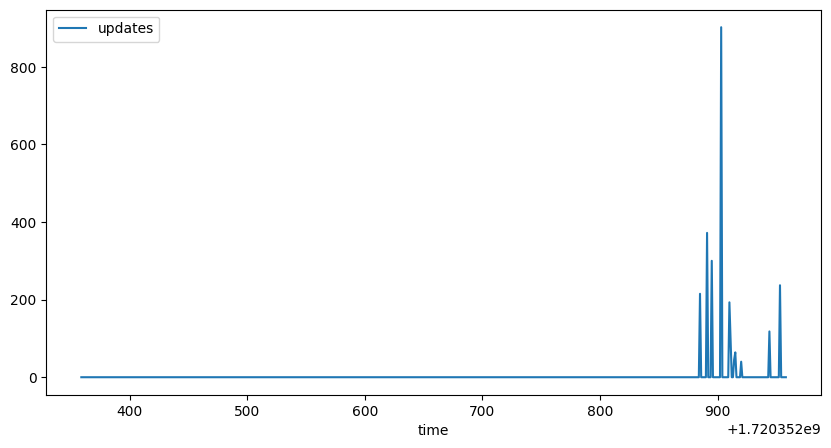

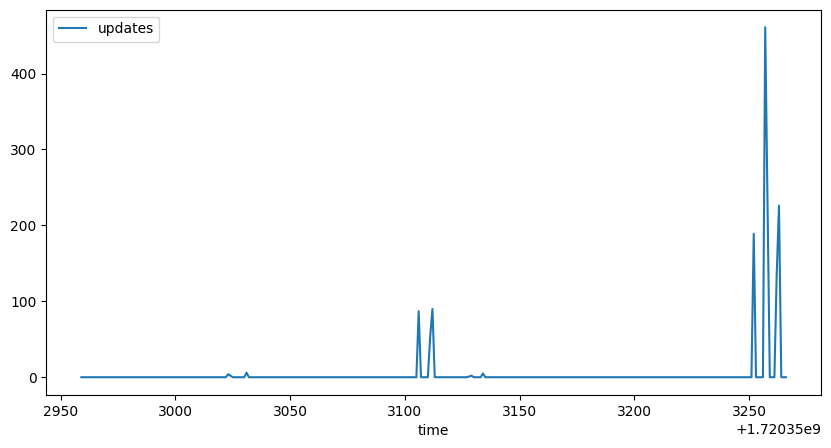

In [9]:
n_samples = 600
n_iters = int(df_17557.shape[0] / n_samples)
for i in range(n_iters):
    ax = df_45609.iloc[i*n_samples: (i+1)*n_samples].plot(y='updates')
    prettify_fig(ax.figure)

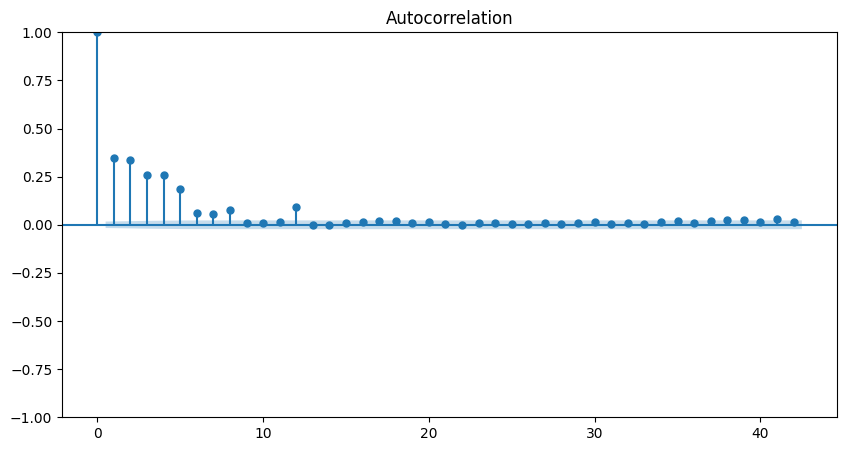

In [10]:
fig = plot_acf(df_45609.updates)
prettify_fig(fig)

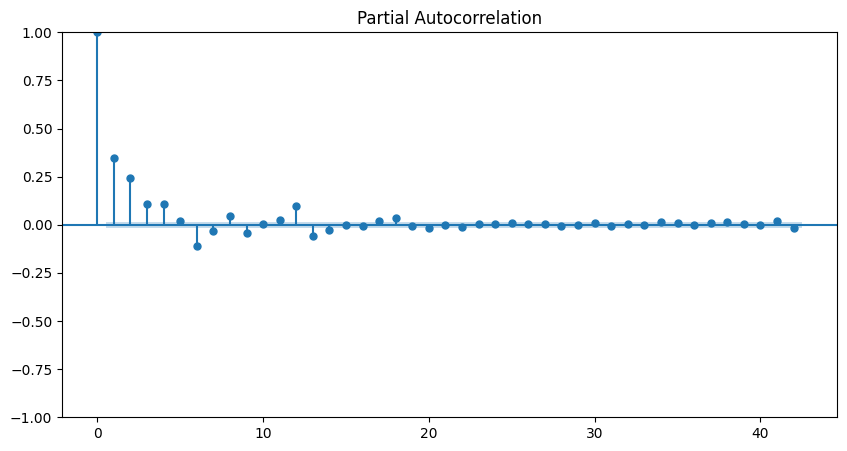

In [58]:
fig = plot_pacf(df_45609.updates)
prettify_fig(fig)

In [35]:
def simulate_arima(time_series, order, trend='c', pred_steps=10, retrain_steps=1, test_size=0.2):
    n_samples = len(time_series)
    if type(test_size)==float:
        pred_start_idx = round(n_samples * (1-test_size))
    elif type(test_size)==int:
        pred_start_idx = n_samples - test_size
    else:
        raise TypeError('test_size should be an integer or a float.')

    print('#Samples:', n_samples, '| Start Training Size:', pred_start_idx, '| Test Size:', n_samples - pred_start_idx)
        
    all_preds = []
    for i in tqdm(range(pred_start_idx, len(time_series))):
        curr_data = time_series.iloc[:i].reset_index(drop=True)
        
        if i == pred_start_idx or (i - pred_start_idx) % retrain_steps == 0:
            model = ARIMA(curr_data, order=order, trend=trend).fit()
            
        y_pred = model.forecast(steps=pred_steps)
        all_preds.append(y_pred)
    
    return all_preds, model

In [54]:
all_preds, model = simulate_arima(df_17557.updates, (19, 0, 12), retrain_steps=600)

#Samples: 14388 | Start Training Size: 11510 | Test Size: 2878


/home/user/Git/pybgpstream-test/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/user/Git/pybgpstream-test/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/user/Git/pybgpstream-test/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/user/Git/pybgpstream-test/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/us

In [55]:
df_preds = pd.DataFrame(np.array(all_preds), columns=[f'day_{i}' for i in range(1, 11)])
y_true = df_17557.updates.iloc[-df_preds.shape[0]:].reset_index(drop=True)
predicted_steps = len(df_preds.columns)

for i in range(1, predicted_steps+1):
    day_col = f'day_{i}'
    y_pred = df_preds[day_col]
    y_true_shifted = y_true.shift(-i+1).dropna()
    y_pred = y_pred.iloc[:y_true_shifted.shape[0]]
    y_pred[y_pred<0] = 0
    print('Predicted Step:', i, '| R2:', r2_score(y_true_shifted, y_pred))

Predicted Step: 1 | R2: -0.0153587690286634
Predicted Step: 2 | R2: -0.033897541607037285
Predicted Step: 3 | R2: -0.005656814852125658
Predicted Step: 4 | R2: -0.01513580401600012
Predicted Step: 5 | R2: -0.0055392535826319644
Predicted Step: 6 | R2: -0.01023225378683601
Predicted Step: 7 | R2: -0.0044578433999455935
Predicted Step: 8 | R2: -0.006522447555063371
Predicted Step: 9 | R2: -0.00573801870534929
Predicted Step: 10 | R2: -0.02130231643256497


In [60]:
all_preds, model = simulate_arima(df_17557.updates, (6, 0, 0), retrain_steps=600)

#Samples: 14388 | Start Training Size: 11510 | Test Size: 2878


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 2878/2878 [01:33<00:00, 30.85it/s]


In [61]:
df_preds = pd.DataFrame(np.array(all_preds), columns=[f'day_{i}' for i in range(1, 11)])
y_true = df_17557.updates.iloc[-df_preds.shape[0]:].reset_index(drop=True)
predicted_steps = len(df_preds.columns)

for i in range(1, predicted_steps+1):
    day_col = f'day_{i}'
    y_pred = df_preds[day_col]
    y_true_shifted = y_true.shift(-i+1).dropna()
    y_pred = y_pred.iloc[:y_true_shifted.shape[0]]
    y_pred[y_pred<0] = 0
    print('Predicted Step:', i, '| R2:', r2_score(y_true_shifted, y_pred))

Predicted Step: 1 | R2: -0.0023062815066072773
Predicted Step: 2 | R2: -0.0016614739379774424
Predicted Step: 3 | R2: -0.0012686541386579542
Predicted Step: 4 | R2: -0.0011472692144169905
Predicted Step: 5 | R2: -0.0010007886949725542
Predicted Step: 6 | R2: -0.0008530938115081099
Predicted Step: 7 | R2: -0.0006928023934507088
Predicted Step: 8 | R2: -0.0006687167810386363
Predicted Step: 9 | R2: -0.0006614692989161952
Predicted Step: 10 | R2: -0.0006560399403525707


In [62]:
all_preds, model = simulate_arima(df_17557.updates, (6, 0, 0), retrain_steps=100)

#Samples: 14388 | Start Training Size: 11510 | Test Size: 2878


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 2878/2878 [08:03<00:00,  5.95it/s]


In [63]:
df_preds = pd.DataFrame(np.array(all_preds), columns=[f'day_{i}' for i in range(1, 11)])
y_true = df_17557.updates.iloc[-df_preds.shape[0]:].reset_index(drop=True)
predicted_steps = len(df_preds.columns)

for i in range(1, predicted_steps+1):
    day_col = f'day_{i}'
    y_pred = df_preds[day_col]
    y_true_shifted = y_true.shift(-i+1).dropna()
    y_pred = y_pred.iloc[:y_true_shifted.shape[0]]
    y_pred[y_pred<0] = 0
    print('Predicted Step:', i, '| R2:', r2_score(y_true_shifted, y_pred))

Predicted Step: 1 | R2: -0.0022478454512784296
Predicted Step: 2 | R2: -0.0018153877878206437
Predicted Step: 3 | R2: -0.0014252099537523932
Predicted Step: 4 | R2: -0.0013359121291711684
Predicted Step: 5 | R2: -0.0011535867077367978
Predicted Step: 6 | R2: -0.0009005222185738404
Predicted Step: 7 | R2: -0.0007607117870975788
Predicted Step: 8 | R2: -0.000742747904776353
Predicted Step: 9 | R2: -0.0007318961120656997
Predicted Step: 10 | R2: -0.000724232775926037


# Prefix

In [66]:
df_prefix_2600 = df[df.prefix=='2600:40fc:1004::/48']
timestamps_extended = np.arange(int(df_prefix_2600.time.min()), int(df_prefix_2600.time.max()))
df_prefix_2600 = df_prefix_2600.astype({'time': int})\
                   .groupby('time')[['prefix']]\
                   .count()\
                   .rename(columns={'prefix': 'updates'})\
                   .reindex(timestamps_extended)\
                   .fillna(0)

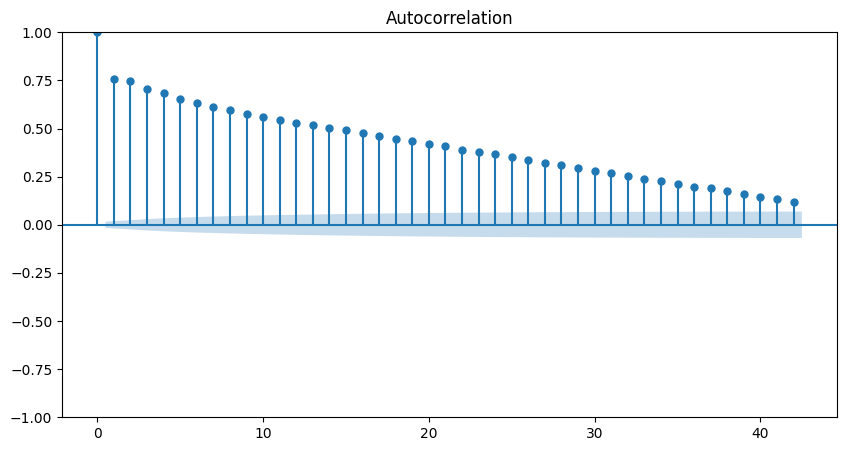

In [73]:
fig = plot_acf(df_prefix_2600.updates)
prettify_fig(fig)

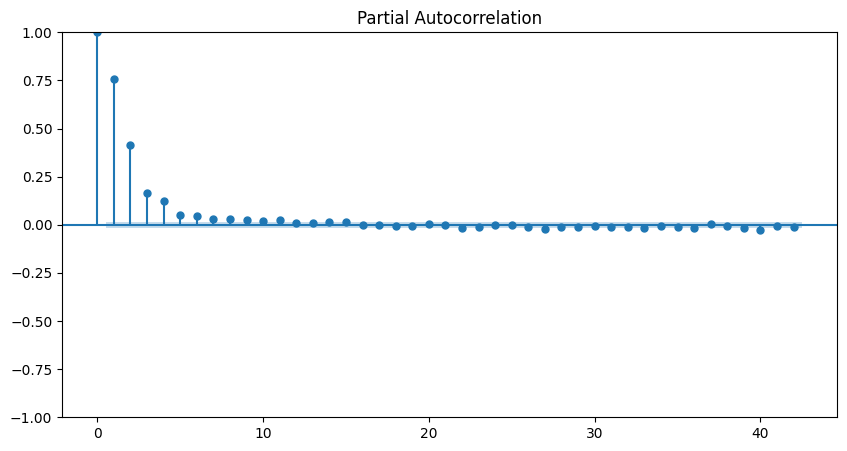

In [68]:
fig = plot_pacf(df_prefix_2600.updates)
prettify_fig(fig)

In [69]:
all_preds, model = simulate_arima(df_prefix_2600.updates, (6, 0, 0), retrain_steps=50)

#Samples: 14374 | Start Training Size: 11499 | Test Size: 2875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 2875/2875 [09:11<00:00,  5.22it/s]


In [71]:
df_preds = pd.DataFrame(np.array(all_preds), columns=[f'day_{i}' for i in range(1, 11)])
y_true = df_17557.updates.iloc[-df_preds.shape[0]:].reset_index(drop=True)
predicted_steps = len(df_preds.columns)

for i in range(1, predicted_steps+1):
    day_col = f'day_{i}'
    y_pred = df_preds[day_col]
    y_true_shifted = y_true.shift(-i+1).dropna()
    y_pred = y_pred.iloc[:y_true_shifted.shape[0]]
    y_pred[y_pred<0] = 0
    print('Predicted Step:', i, '| R2:', r2_score(y_true_shifted, y_pred))

Predicted Step: 1 | R2: -0.009249154160977824
Predicted Step: 2 | R2: -0.0091030180078846
Predicted Step: 3 | R2: -0.00843383748573534
Predicted Step: 4 | R2: -0.008301510349409513
Predicted Step: 5 | R2: -0.0077449001611784585
Predicted Step: 6 | R2: -0.007478802284377473
Predicted Step: 7 | R2: -0.007096496874010594
Predicted Step: 8 | R2: -0.006787429180046267
Predicted Step: 9 | R2: -0.006329262462113183
Predicted Step: 10 | R2: -0.0049993496154396855


In [74]:
all_preds, model = simulate_arima(df_prefix_2600.updates, (4, 0, 4), retrain_steps=50)

#Samples: 14374 | Start Training Size: 11499 | Test Size: 2875


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 2875/2875 [40:35<00:00,  1.18it/s]


In [75]:
df_preds = pd.DataFrame(np.array(all_preds), columns=[f'day_{i}' for i in range(1, 11)])
y_true = df_17557.updates.iloc[-df_preds.shape[0]:].reset_index(drop=True)
predicted_steps = len(df_preds.columns)

for i in range(1, predicted_steps+1):
    day_col = f'day_{i}'
    y_pred = df_preds[day_col]
    y_true_shifted = y_true.shift(-i+1).dropna()
    y_pred = y_pred.iloc[:y_true_shifted.shape[0]]
    y_pred[y_pred<0] = 0
    print('Predicted Step:', i, '| R2:', r2_score(y_true_shifted, y_pred))

Predicted Step: 1 | R2: -0.009222069304247515
Predicted Step: 2 | R2: -0.00905727203617035
Predicted Step: 3 | R2: -0.008477789043483286
Predicted Step: 4 | R2: -0.00841990675004789
Predicted Step: 5 | R2: -0.008015437084650356
Predicted Step: 6 | R2: -0.007795676374624305
Predicted Step: 7 | R2: -0.007509512271766772
Predicted Step: 8 | R2: -0.007287966747723695
Predicted Step: 9 | R2: -0.0068749396107752325
Predicted Step: 10 | R2: -0.005501402060728244
